# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from datetime import datetime
import pandas as pd
from feature_engine.selection import SmartCorrelatedSelection
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [ ]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')
# Assuming your DataFrame is named df and the column you want to convert is named 'col_name'
df['has_gas'].replace({'t': 1, 'f': 0}, inplace=True)

In [ ]:
df.head(3)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   

   var_6m_price_off_peak_var  var_6m_price_peak_var  \
0                   0.000131           4.100838e-05   
1                   0.000003           1.217891e-03   
2                   0.000004           9.450150e-08   

   var_6m_price_mid_peak_var  var_6m_price_off_peak_fix  \
0                   0.000908                   2.086294   
1                   0.000000                   0.009482   
2                   0.000000                   0.000000   

   var_6m_price_peak_fix  var_6m_price_mid_peak_fix  var_6m_price_off_peak  \
0              99.530517                  44.235794               2.086425   
1               0.000000                   0.000000               0.009485   
2               0.000000                   0.000000               0.000004   

   var_6m_price_peak  var_6m_price_mid_peak  churn  
0       9.953056e+01              44.236702      1  
1       1.217891e-03               0.000000      0  
2       9.450150e-08               0.000000      0  

[3 rows x 44 columns]

Maximum change in prices across periods.

In [ ]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [ ]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  var_6m_price_off_peak  \
0      2015-11-01   2015-06-23               0.00  ...               2.086425   
1      2009-08-21   2015-08-31             189.95  ...               0.009485   
2      2010-04-16   2015-04-17              47.96  ...               0.000004   
3      2010-03-30   2015-03-31             240.04  ...               0.000003   
4      2010-01-13   2015-03-09             445.75  ...               0.000011   

   var_6m_price_peak  var_6m_price_mid_peak  churn  \
0       9.953056e+01           4.423670e+01      1   
1       1.217891e-03           0.000000e+00      0   
2       9.450150e-08           0.000000e+00      0   
3       0.000000e+00           0.000000e+00      0   
4       2.896760e-06           4.860000e-10      0   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                            0.060550                            0.085483   
1                            0.151367                            0.085483   
2                            0.084587                            0.089162   
3                            0.153133                            0.000000   
4                            0.022225                            0.033743   

   off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                                0.146033                           44.266930   
1                                0.151367                           44.444710   
2                                0.172468                           44.444710   
3                                0.153133                           44.444710   
4                                0.055866                           16.291555   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                            8.145775                                44.26693  
1                            0.000000                                44.44471  
2                            0.000000                                44.44471  
3                            0.000000                                44.44471  
4                            8.145775                                24.43733  

[5 rows x 50 columns]

Determing the total tenure of the clents. Long standing client tend to continue and new clients more than often try to look for new options

In [ ]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)

Months since last renewal. Clients who renewd recently are most likely to stay with the company.

In [ ]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

# Create reference date
reference_date = datetime(2016, 1, 1)
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)

Create dummy variables for Channel sales and Origin up column to make more sense

In [ ]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])

In [ ]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   
3                    19.83                        0.146694   
4                   131.73                        0.116900   

   forecast_price_energy_peak  ...  tenure  months_renewal  channel_MISSING  \
0                    0.098142  ...       3               6                0   
1                    0.000000  ...       7               4                1   
2                    0.087899  ...       6               8                0   
3                    0.000000  ...       6               9                0   
4                    0.100015  ...       6               9                1   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 54 columns]

We know that there are several columns which are highly skewed. That means there are quite a few outliers. To treat this problem, we take log of those values. Generally log, square root gives us values which tends to follow normal distributions. Normally distributed values fit more accurate than skewed data

In [ ]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.795000   
75%           1745.750000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14606.000000  
mean                     43.130056  
std                       4.485988  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

In [ ]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14606.000000  14606.000000     14606.000000       14606.000000   
mean       4.223939      0.779244         2.264646           2.962177   
std        0.884515      1.717071         1.769305           0.683592   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.754023      0.000000         0.000000           2.695477   
50%        4.149727      0.000000         2.899547           3.046836   
75%        4.610285      0.000000         3.529430           3.380716   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean             1.784610                  0.966726                 1.517203   
std              1.584986                  5.108289                 0.571481   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.235023   
50%              2.498311                  0.000000                 1.296555   
75%              3.242231                  0.000000                 2.120673   
max              5.243970                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14606.000000  
mean                     43.130056  
std                       4.485988  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

<ipython-input-191-f63759cfd0e3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
<ipython-input-191-f63759cfd0e3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
<ipython-input-191-f63759cfd0e3>:5

Plotting the Correlation matrix to possibly remove highly correlated features

<ipython-input-192-1849d975b202>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


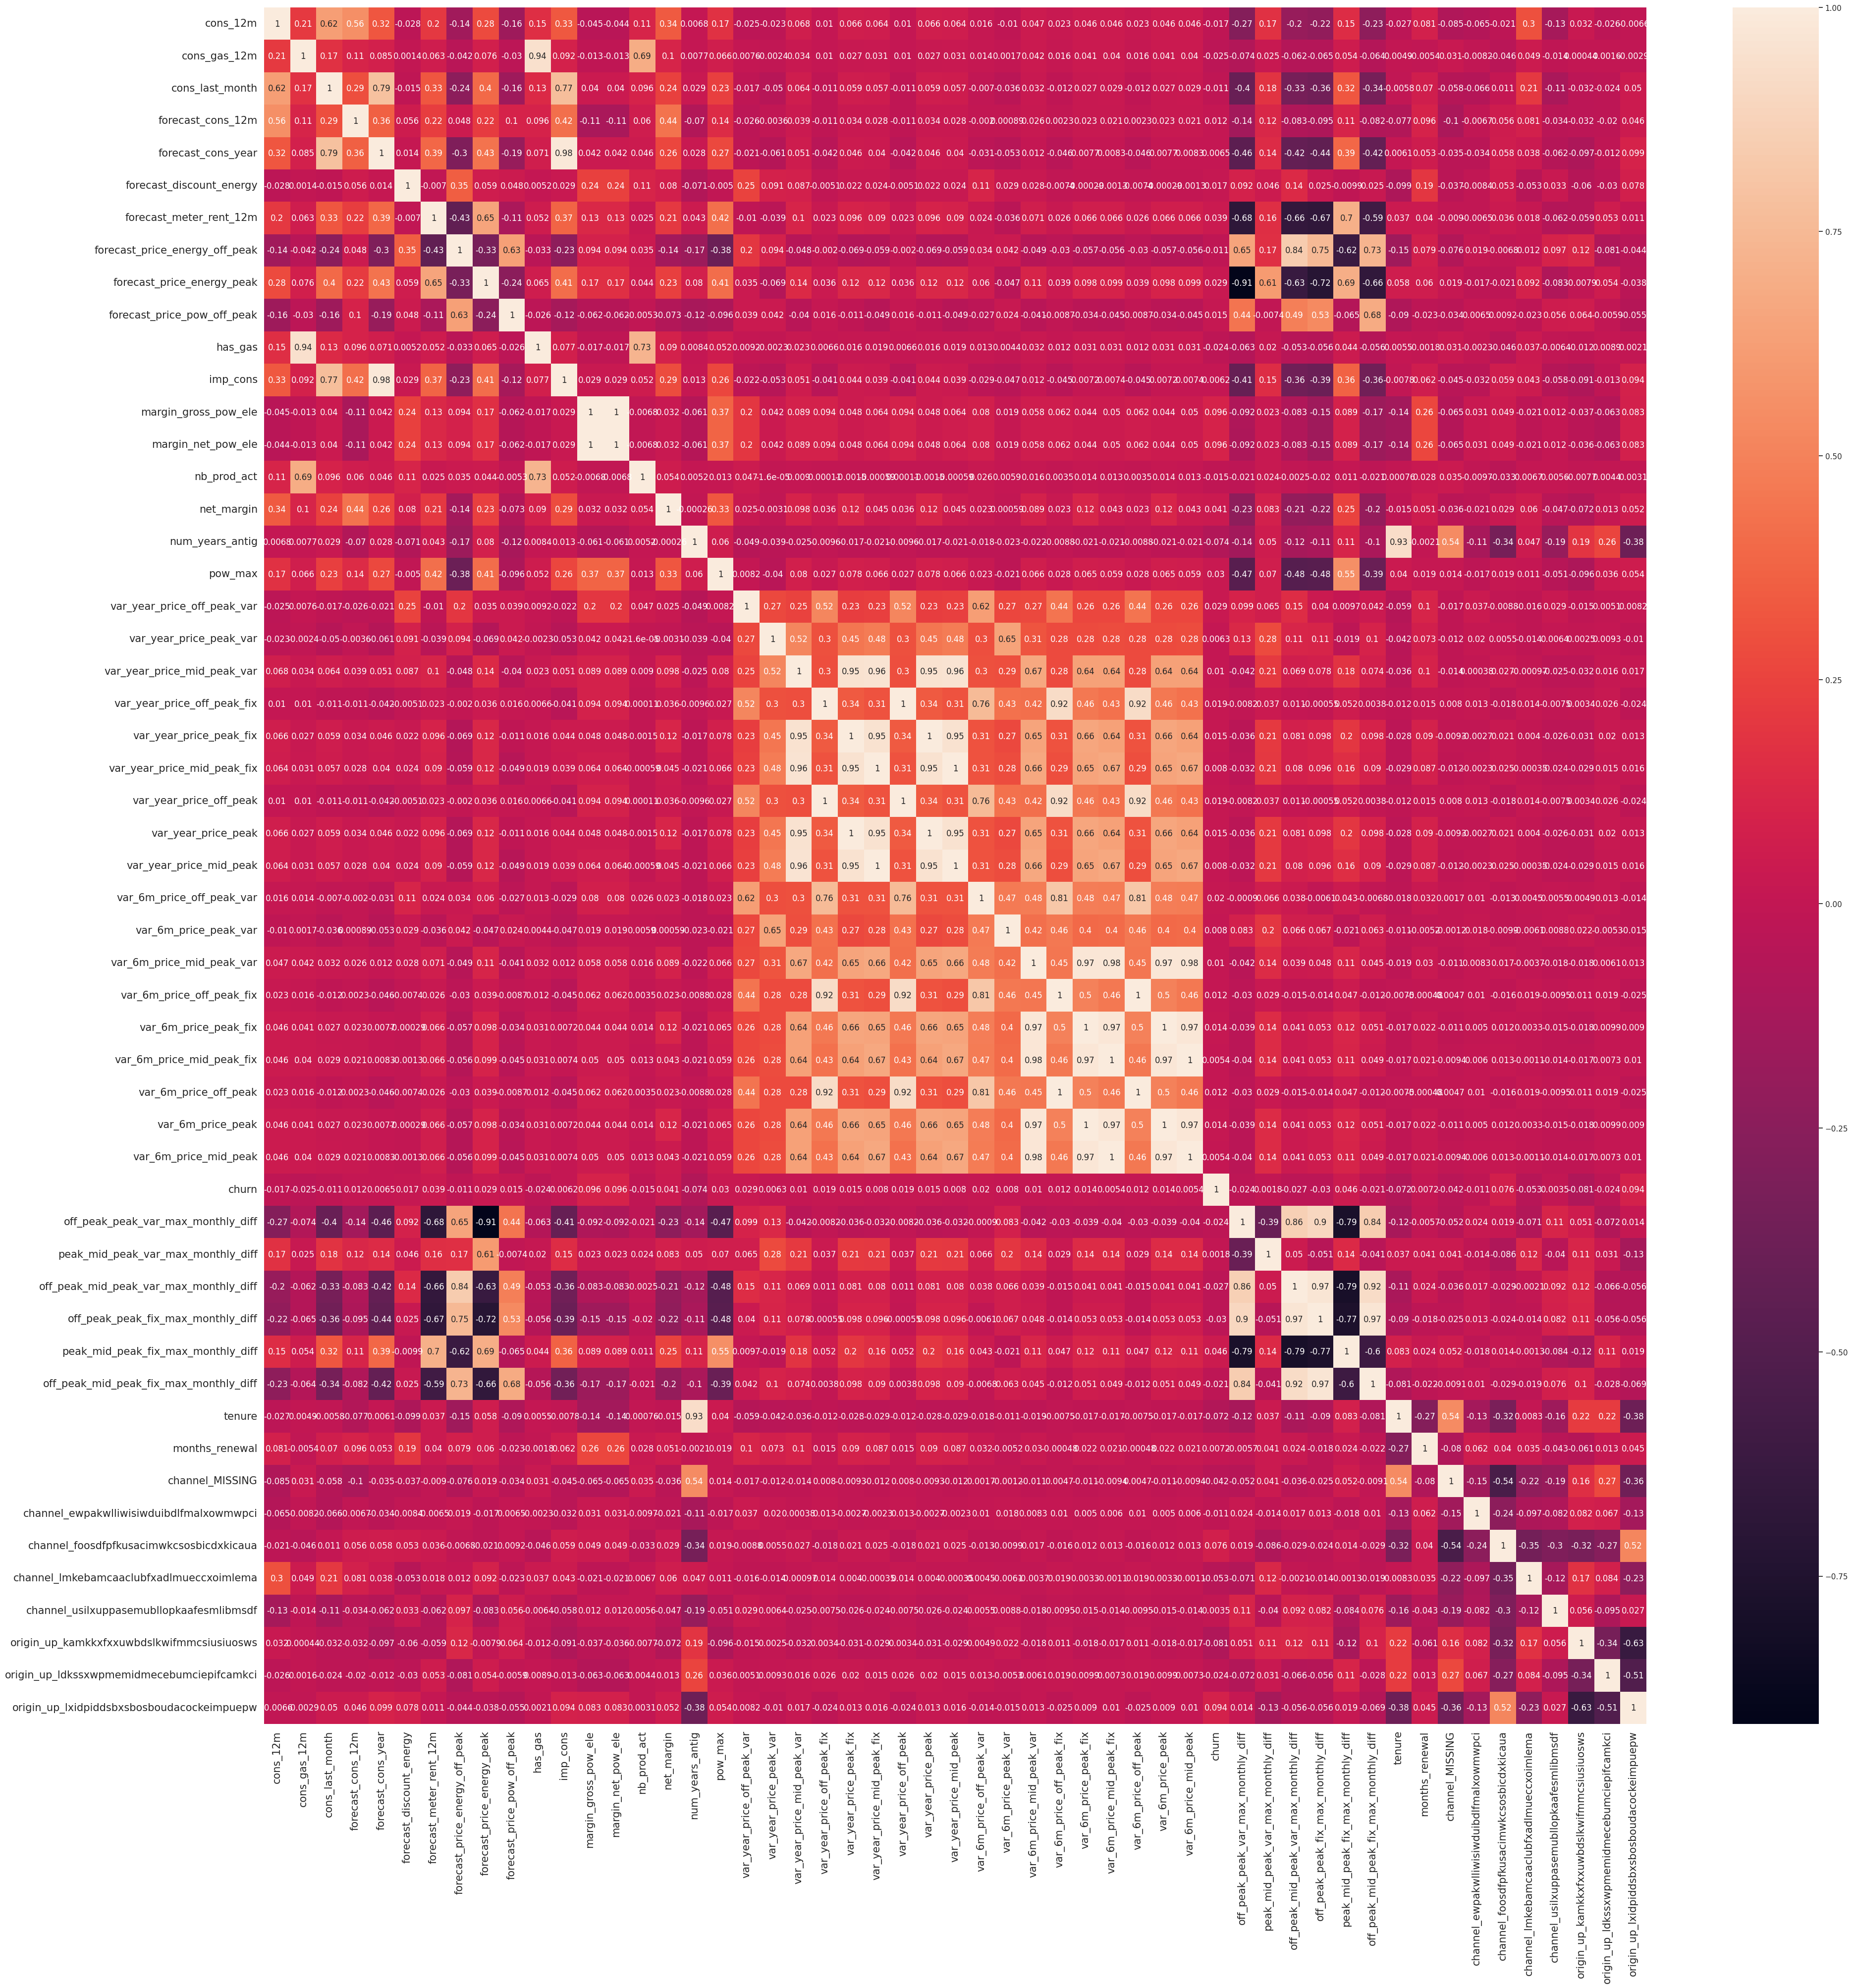

In [ ]:
correlation = df.corr()

# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

There are quite a lot of highy correlated featues such as tenure, offpeak_peak difference of power and price etc which are highly correlated to other independent variables. It is better to remove or combine them into a single column so that the model will not be complex and easy to train

Using PCA, threshold as 0.7

In [ ]:
df = df.drop(columns=['id'])

In [ ]:
# Compute the correlation matrix
corr_matrix = df.corr().abs()

# Get the indices of highly correlated columns
threshold = 0.7
highly_correlated_columns = (corr_matrix > threshold).sum() > 1

highly_correlated_df = df[df.columns[highly_correlated_columns]]

highly_correlated_df

cons_gas_12m  cons_last_month  forecast_cons_year  \
0          4.739944         0.000000            0.000000   
1          0.000000         0.000000            0.000000   
2          0.000000         0.000000            0.000000   
3          0.000000         0.000000            0.000000   
4          0.000000         2.721811            2.721811   
...             ...              ...                 ...   
14601      4.680707         0.000000            0.000000   
14602      0.000000         2.260071            2.260071   
14603      0.000000         2.255273            2.255273   
14604      0.000000         0.000000            0.000000   
14605      0.000000         0.000000            0.000000   

       forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     0.444045                        0.114481   
1                     1.237292                        0.145711   
2                     1.599009                        0.165794   
3                     1.318689                        0.146694   
4                     2.122969                        0.116900   
...                        ...                             ...   
14601                 1.291591                        0.138305   
14602                 2.161458                        0.100167   
14603                 2.115943                        0.116900   
14604                 0.912753                        0.145711   
14605                 0.315970                        0.167086   

       forecast_price_energy_peak  has_gas  imp_cons  margin_gross_pow_ele  \
0                        0.098142        1  0.000000                 25.44   
1                        0.000000        0  0.000000                 16.38   
2                        0.087899        0  0.000000                 28.60   
3                        0.000000        0  0.000000                 30.22   
4                        0.100015        0  1.726890                 44.91   
...                           ...      ...       ...                   ...   
14601                    0.000000        1  0.000000                 27.88   
14602                    0.091892        0  1.228913                  0.00   
14603                    0.100015        0  1.279895                 39.84   
14604                    0.000000        0  0.000000                 13.08   
14605                    0.088454        0  0.000000                 11.84   

       margin_net_pow_ele  ...  var_6m_price_mid_peak_fix  \
0                   25.44  ...                  44.235794   
1                   16.38  ...                   0.000000   
2                   28.60  ...                   0.000000   
3                   30.22  ...                   0.000000   
4                   44.91  ...                   0.000000   
...                   ...  ...                        ...   
14601               27.88  ...                   0.000000   
14602                0.00  ...                   0.000299   
14603               39.84  ...                   0.000000   
14604               13.08  ...                   0.000000   
14605               11.84  ...                   0.000000   

       var_6m_price_off_peak  var_6m_price_peak  var_6m_price_mid_peak  \
0                   2.086425       9.953056e+01           4.423670e+01   
1                   0.009485       1.217891e-03           0.000000e+00   
2                   0.000004       9.450150e-08           0.000000e+00   
3                   0.000003       0.000000e+00           0.000000e+00   
4                   0.000011       2.896760e-06           4.860000e-10   
...                      ...                ...                    ...   
14601               0.000003       0.000000e+00           0.000000e+00   
14602               0.014948       5.684001e-03           2.987132e-04   
14603               0.000011       2.896760e-06           4.860000e-10   
14604               0.009485       1.217891e-03           0.000000e+00   
14605    

In [ ]:
# Apply PCA to the highly correlated columns
pca = PCA()
pca.fit(highly_correlated_df)

# Transform the highly correlated columns into principal components
components = pca.transform(highly_correlated_df)

# Create a DataFrame from the principal components
components_df = pd.DataFrame(components, columns=[f"PC{i+1}" for i in range(components.shape[1])])

# Concatenate the principal components with the original DataFrame
df_combined = pd.concat([df.drop(columns=highly_correlated_df.columns), components_df], axis=1)

In [ ]:
correlation = df_combined.corr()

# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()